# Read university info from duckdb

And then run some loops over all of them...


This notenook is a a bit of a mess, as it was mostly experimenting and hacking on the DSC away day. If you want info, explanation, discussion, etc., drop Marcel an email at m.r.haas@uva.nl.

In [1]:
path = 'data/dutchuniversities.duckdb'

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
con = duckdb.connect(database=path, read_only=True)

In [4]:
df = con.execute("SELECT * FROM dutch_universities").df()


In [5]:
con.execute("SHOW TABLES")
print(con.fetchall())

[('dutch_universities',)]


In [6]:
import os
os.getcwd()

'/home/marcel/projects_local/WikiCompare'

In [7]:
df

,wikidataid,label,en_site,nl_site,enpage,nlpage,wikidatarep
0,Q422208,Wageningen University & Research,[[Wageningen University & Research]],[[Wageningen University & Research]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...
1,Q2291320,University of Nijmegen (1655–1680),[[University of Nijmegen (1655–1680)]],[[Kwartierlijke Academie van Nijmegen]],[[File:Commanderie St. Jan Nijmegen.JPG|thumb|...,De '''Kwartierlijke Academie van Nijmegen''' w...,{'labels': <class 'pywikibot.page._collections...
2,Q632004,Radboud University Nijmegen,[[Radboud University Nijmegen]],[[Radboud Universiteit]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...
3,Q1293929,University of Franeker,[[University of Franeker]],[[Universiteit van Franeker]],{{refimprove|date=December 2013}}\n[[File:Univ...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...
4,Q221653,Utrecht University,[[Utrecht University]],[[Universiteit Utrecht]],{{short description|Public research university...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...
5,Q156598,Leiden University,[[Leiden University]],[[Universiteit Leiden]],{{Short description|University in the Netherla...,{{Infobox universiteit\n| naam ...,{'labels': <class 'pywikibot.page._collections...
6,Q1137652,Maastricht University,[[Maastricht University]],[[Universiteit Maastricht]],{{short description|Public university in Maast...,{{Infobox universiteit\n| naam = Universiteit ...,{'labels': <class 'pywikibot.page._collections...
7,Q1711630,University of Humanistic Studies,[[University of Humanistic Studies]],[[Universiteit voor Humanistiek]],{{Infobox university\n |name = Un...,{{Infobox universiteit\n| naam = Universiteit ...,{'labels': <class 'pywikibot.page._collections...
8,Q850730,University of Groningen,[[University of Groningen]],[[Rijksuniversiteit Groningen]],{{Short description|Public university in Groni...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...
9,Q2725923,Catholic University of Utrecht,[[Catholic University of Utrecht]],[[Katholieke Theologische Universiteit Utrecht]],{{notability|Companies|date=November 2017}}\nT...,De '''Katholieke Theologische Universiteit''' ...,{'labels': <class 'pywikibot.page._collections...


In [5]:
import wikitextparser as wtp
import pywikibot # https://www.mediawiki.org/wiki/Manual:Pywikibot

import spacy

In [6]:
wiki_en_site = pywikibot.Site('en', 'wikipedia')
wiki_nl_site = pywikibot.Site('nl', 'wikipedia')

In [7]:
english = spacy.load("en_core_web_sm")
dutch = spacy.load("nl_core_news_sm")
ml = spacy.load("xx_ent_wiki_sm")


In [8]:
def unique_ents(doc):
    all_ents = {}
    for ent in doc.ents:
        if ent.text in all_ents:
            if ent.label_ != all_ents[ent.text]: 
                # print(f'Different labels for {ent.text}: {ent.label_} vs {all_ents[ent.text]}.')
                # Replace MISC, for th rest: no clue which one was true...
                if all_ents[ent.text] == "MISC":
                    all_ents[ent.text] = ent.label_
        else: all_ents[ent.text] = ent.label_
        
    return all_ents

In [9]:
nl_en = []
nl_en_pure = []
names = []
NER_en = []
NER_nl = []
NER_en_pure = []
NER_nl_pure = []
for uni in zip(df.en_site, df.nl_site):
    page_en = pywikibot.Page(wiki_en_site, uni[0][2:-2])
    page_nl = pywikibot.Page(wiki_nl_site, uni[1][2:-2])
    
    plain_en = wtp.parse(page_en.text).plain_text()
    plain_nl = wtp.parse(page_nl.text).plain_text()

    multi_en = ml(plain_en)
    multi_nl = ml(plain_nl)
    nl = dutch(plain_nl)
    en = english(plain_en)
    
    nl_en.append(len(unique_ents(multi_nl))/len(unique_ents(multi_en)))
    nl_en_pure.append(len(unique_ents(nl))/len(unique_ents(en)))
    names.append(uni[0][2:-2])
    NER_en.append(len(unique_ents(multi_en)))
    NER_nl.append(len(unique_ents(multi_nl)))
    NER_en_pure.append(len(unique_ents(en)))
    NER_nl_pure.append(len(unique_ents(nl)))
    
    
df['Dutch_over_english'] = nl_en
df['Dutch_over_english_pure'] = nl_en_pure
df['University'] = names
df["Number_entities_en"] = NER_en
df["Number_entities_nl"] = NER_nl
df["Number_entities_en_pure"] = NER_en_pure
df["Number_entities_nl_pure"] = NER_nl_pure

                       

In [13]:
df.head()

,wikidataid,label,en_site,nl_site,enpage,nlpage,wikidatarep,Dutch_over_english,Dutch_over_english_pure,University,Number_entities_en,Number_entities_nl,Number_entities_en_pure,Number_entities_nl_pure
0,Q422208,Wageningen University & Research,[[Wageningen University & Research]],[[Wageningen University & Research]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,0.829268,0.870787,Wageningen University & Research,123,102,178,155
1,Q2291320,University of Nijmegen (1655–1680),[[University of Nijmegen (1655–1680)]],[[Kwartierlijke Academie van Nijmegen]],[[File:Commanderie St. Jan Nijmegen.JPG|thumb|...,De '''Kwartierlijke Academie van Nijmegen''' w...,{'labels': <class 'pywikibot.page._collections...,2.444444,2.378378,University of Nijmegen (1655–1680),27,66,37,88
2,Q632004,Radboud University Nijmegen,[[Radboud University Nijmegen]],[[Radboud Universiteit]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.054688,1.000000,Radboud University Nijmegen,256,270,361,361
3,Q1293929,University of Franeker,[[University of Franeker]],[[Universiteit van Franeker]],{{refimprove|date=December 2013}}\n[[File:Univ...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.137931,1.093220,University of Franeker,87,99,118,129
4,Q221653,Utrecht University,[[Utrecht University]],[[Universiteit Utrecht]],{{short description|Public research university...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.342342,1.251656,Utrecht University,111,149,151,189


In [12]:
df[['wikidataid', 'label', 'en_site', 'nl_site', 'Number_entities_nl', 'Number_entities_en', 'Number_entities_nl_pure', 'Number_entities_en_pure']].to_csv('/home/marcel/projects_local/WikiCompare/data/df_with_entities.csv')

Text(0, 0.5, 'Same, but "pure" language models')

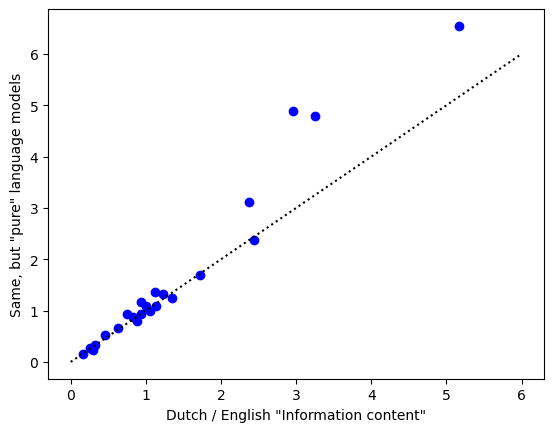

In [15]:
plt.plot(df.Dutch_over_english, df.Dutch_over_english_pure, 'bo')
plt.plot([0,6], [0,6], "k:")
plt.xlabel('Dutch / English "Information content"')
plt.ylabel('Same, but "pure" language models')

In [13]:
ratios = df["Dutch_over_english"]

In [11]:
df.to_pickle('df_unis.pkl')

In [14]:
type(ratios), len(ratios)

(pandas.core.series.Series, 23)

In [15]:
print(ratios)

0     0.829268
1     2.444444
2     1.054688
3     1.137931
4     1.342342
5     0.942085
6     1.231362
7     5.166667
8     0.876877
9     3.250000
10    0.290419
11    0.161290
12    0.635910
13    1.000000
14    0.317073
15    0.753623
16    2.377778
17    1.719298
18    0.938462
19    2.953488
20    1.127660
21    0.457447
22    0.260997
Name: Dutch_over_english, dtype: float64


Text(0, 0.5, '# Universities')

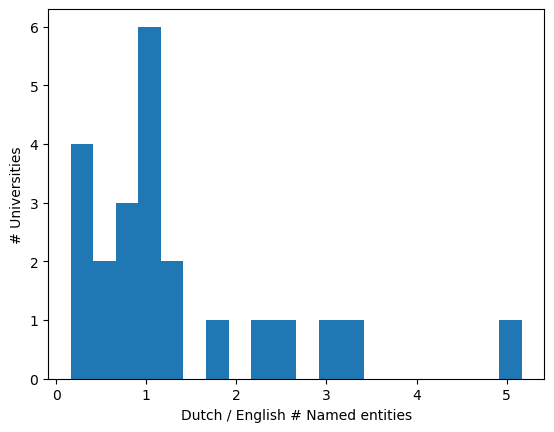

In [17]:
plt.hist(ratios,bins=20)
plt.xlabel("Dutch / English # Named entities")
plt.ylabel("# Universities")

In [1]:
import pandas as pd
with open('df_unis.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df.head()

,wikidataid,label,en_site,nl_site,enpage,nlpage,wikidatarep,Dutch_over_english,Dutch_over_english_pure,University
0,Q422208,Wageningen University & Research,[[Wageningen University & Research]],[[Wageningen University & Research]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,0.829268,0.870787,Wageningen University & Research
1,Q2291320,University of Nijmegen (1655–1680),[[University of Nijmegen (1655–1680)]],[[Kwartierlijke Academie van Nijmegen]],[[File:Commanderie St. Jan Nijmegen.JPG|thumb|...,De '''Kwartierlijke Academie van Nijmegen''' w...,{'labels': <class 'pywikibot.page._collections...,2.444444,2.378378,University of Nijmegen (1655–1680)
2,Q632004,Radboud University Nijmegen,[[Radboud University Nijmegen]],[[Radboud Universiteit]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.054688,1.000000,Radboud University Nijmegen
3,Q1293929,University of Franeker,[[University of Franeker]],[[Universiteit van Franeker]],{{refimprove|date=December 2013}}\n[[File:Univ...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.137931,1.093220,University of Franeker
4,Q221653,Utrecht University,[[Utrecht University]],[[Universiteit Utrecht]],{{short description|Public research university...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.342342,1.251656,Utrecht University


In [4]:
r = df.Dutch_over_english_pure.values

In [ ]:
r